In [143]:
import h5py

In [7]:
import numpy as np
import nibabel as nib
from scipy.ndimage.interpolation import zoom
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import nilearn
import pandas as pd

#from utils import load_nifti, resample_mask, load_masked_nifti, write_total_file_list
import matplotlib.pyplot as plt
import os
import re
import time
import itertools

# keras
from keras.models import Sequential # Model
from keras.layers import Input,Conv3D, Conv2D, Flatten, Dense, MaxPooling3D, MaxPooling2D,Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import RMSprop, SGD, Adam
from keras.models import load_model
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence

import sys
sys.path.insert(0, "..")
from config import *

In [8]:
z_factor = 0.528 # leads to (96, 115, 96)
z_slice = 96

In [76]:
df = pd.read_csv(doc_dir)
df.head()

,file,label,name,path,time
0,VIMS_MS_027_1_FLAIR.nii.gz,MS,VIMS_MS_027,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_02...,1.0
1,VIMS_MS_043_1_FLAIR.nii.gz,MS,VIMS_MS_043,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_04...,1.0
2,VIMS_MS_141_1_FLAIR.nii.gz,MS,VIMS_MS_141,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_14...,1.0
3,VIMS_MS_137_1_FLAIR.nii.gz,MS,VIMS_MS_137,/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_13...,1.0
4,VIMS_HC_022_1_FLAIR.nii.gz,HC,VIMS_HC_022,/analysis/share/Ritter/MS/CIS/02_HC/VIMS_HC_02...,1.0


In [77]:
from scipy.ndimage.interpolation import zoom
def load_nifti(file_path, dtype=np.float32, incl_header=False, z_factor=None, mask=None):
    """
    Loads a volumetric image in nifti format (extensions .nii, .nii.gz etc.)
    as a 3D numpy.ndarray.
    
    Args:
        file_path: absolute path to the nifti file
        
        dtype(optional): datatype of the loaded numpy.ndarray
        
        incl_header(bool, optional): If True, the nifTI object of the 
        image is also returned.
        
        z_factor(float or sequence, optional): The zoom factor along the
        axes. If a float, zoom is the same for each axis. If a sequence,
        zoom should contain one value for each axis.
        
        mask(ndarray, optional): A mask with the same shape as the
        original image. If provided then the mask is element-wise
        multiplied with the image ndarray
    
    Returns:
        3D numpy.ndarray with axis order (saggital x coronal x axial)
    """
    
    img = nib.load(file_path)
    struct_arr = img.get_data().astype(dtype)
    
    # replace infinite values with 0
    if np.inf in struct_arr:
        struct_arr[struct_arr == np.inf] = 0.
    
    # replace NaN values with 0    
    if np.isnan(struct_arr).any() == True:
        struct_arr[np.isnan(struct_arr)] = 0.
        
    if mask is not None:
        struct_arr *= mask
        
    if z_factor is not None:
        struct_arr = zoom(struct_arr, z_factor)
    
    if incl_header:
        return struct_arr, img
    else:
        return struct_arr

In [78]:
df["path"][0]

'/analysis/share/Ritter/MS/CIS/03_MS/VIMS_MS_027/VIMS_MS_027_1/BET_VIMS_MS_027_1_FLAIR.nii.gz'

## Compute lesion mask

In [79]:
cross_kernel = np.zeros(shape=(3, 3, 3))
cross_kernel[1,:,:] = 1.
cross_kernel[:,1,:] = 1.
cross_kernel[:,:,1] = 1.

In [138]:
#all_lesion_maks = np.empty(shape=((len(df),) + shape))
#lesion_sum = np.zeros(shape=shape)
lesion_sum_filtered = np.zeros(shape=(182,217,182))
for idx, row in df.iterrows():
    path = row["path"].replace("FLAIR", "T2LESION_QC")
    path = path.replace("BET_", "")
    try:
        img = load_nifti(path)#, z_factor=z_factor)
    except:
        print("File not found {}".format(row["file"]))
    # convolve with kernel
    filtered = signal.convolve(img, kernel, mode="same")
    lesion_sum_filtered += filtered[:,1:,:]

File not found VIMS_MS_149_1_FLAIR.nii.gz
File not found VIMS_MS_077_1_FLAIR.nii.gz
File not found RS_GK_022_1_FLAIR.nii.gz
File not found RS_GK_015_1_FLAIR.nii.gz


In [91]:
#all_lesion_maks = np.empty(shape=((len(df),) + shape))
#lesion_sum = np.zeros(shape=shape)
lesion_sum = np.zeros(shape=(182,217,182))
for idx, row in df.iterrows():
    path = row["path"].replace("FLAIR", "T2LESION_QC")
    path = path.replace("BET_", "")
    try:
        img = load_nifti(path)#, z_factor=z_factor)
    except:
        print("File not found {}".format(row["file"]))
    lesion_sum += img[:,1:,:]

File not found VIMS_MS_149_1_FLAIR.nii.gz
File not found VIMS_MS_077_1_FLAIR.nii.gz
File not found RS_GK_022_1_FLAIR.nii.gz
File not found RS_GK_015_1_FLAIR.nii.gz


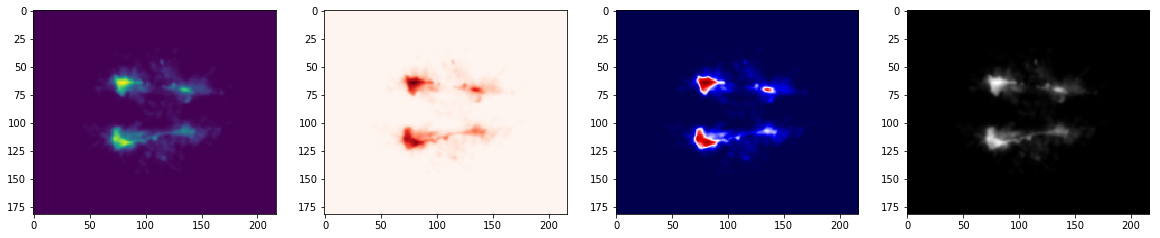

In [140]:
plt.figure(figsize=(20, 10))
plt.title("All convolved lesions summed")
plt.subplot(1, 4, 1)
plt.imshow(lesion_sum_filtered[:,:,z_slice])#, cmap='Reds')
plt.subplot(1, 4, 2)
plt.imshow(lesion_sum_filtered[:,:,z_slice], cmap='Reds')
plt.subplot(1, 4, 3)
plt.imshow(lesion_sum_filtered[:,:,z_slice], cmap='seismic')
plt.subplot(1, 4, 4)
plt.imshow(lesion_sum_filtered[:,:,z_slice], cmap='gray')
plt.show()


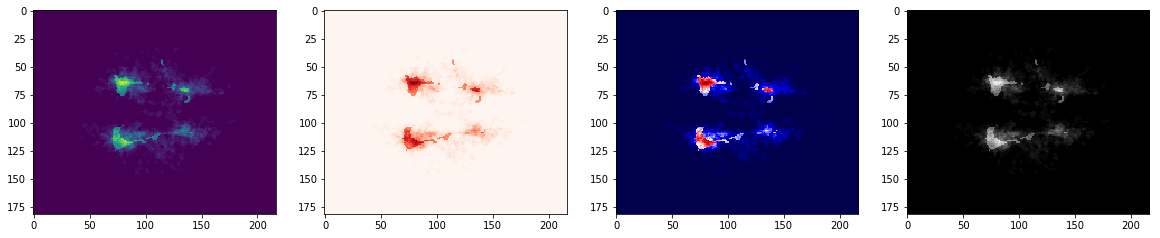

In [95]:
plt.figure(figsize=(20, 10))
plt.title("All lesions summed")
plt.subplot(1, 4, 1)
plt.imshow(lesion_sum[:,:,z_slice])#, cmap='Reds')
plt.subplot(1, 4, 2)
plt.imshow(lesion_sum[:,:,z_slice], cmap='Reds')
plt.subplot(1, 4, 3)
plt.imshow(lesion_sum[:,:,z_slice], cmap='seismic')
plt.subplot(1, 4, 4)
plt.imshow(lesion_sum[:,:,z_slice], cmap='gray')
plt.show()


In [93]:
lesion_sum[:,:,96]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
lesion_mask = (lesion_sum != 0) *1

## By label

In [149]:
#all_lesion_maks = np.empty(shape=((len(df),) + shape))
#lesion_sum = np.zeros(shape=shape)
MS_lesion_sum = np.zeros(shape=(182,217,182))
HC_lesion_sum = np.zeros(shape=(182,217,182))
for idx, row in df.iterrows():
    
    path = row["path"].replace("FLAIR", "T2LESION_QC")
    path = path.replace("BET_", "")
    try:
        img = load_nifti(path)#, z_factor=z_factor)
        if row["label"] == "MS":
            MS_lesion_sum += img[:,1:,:]
        else:
            HC_lesion_sum += img[:,1:,:]
    except:
        print("File not found {}".format(row["file"]))

File not found VIMS_MS_149_1_FLAIR.nii.gz
File not found VIMS_MS_077_1_FLAIR.nii.gz
File not found RS_GK_022_1_FLAIR.nii.gz
File not found RS_GK_015_1_FLAIR.nii.gz


In [155]:
vmin = np.min(MS_lesion_sum)
vmax = np.max(MS_lesion_sum)

MS lesions


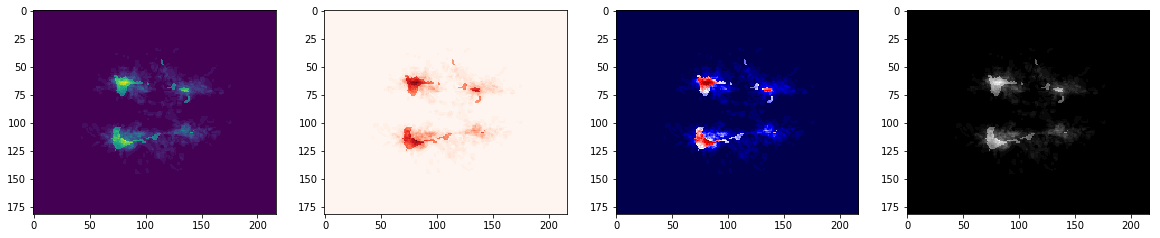

In [163]:
print("MS lesions")
plt.figure(figsize=(20, 10))
plt.title("All MS lesions summed")
plt.subplot(1, 4, 1)
plt.imshow(MS_lesion_sum[:,:,z_slice])#, cmap='Reds')
plt.subplot(1, 4, 2)
plt.imshow(MS_lesion_sum[:,:,z_slice], cmap='Reds')
plt.subplot(1, 4, 3)
plt.imshow(MS_lesion_sum[:,:,z_slice], cmap='seismic',)
plt.subplot(1, 4, 4)
plt.imshow(MS_lesion_sum[:,:,z_slice], cmap='gray')

plt.show()

HC lesions


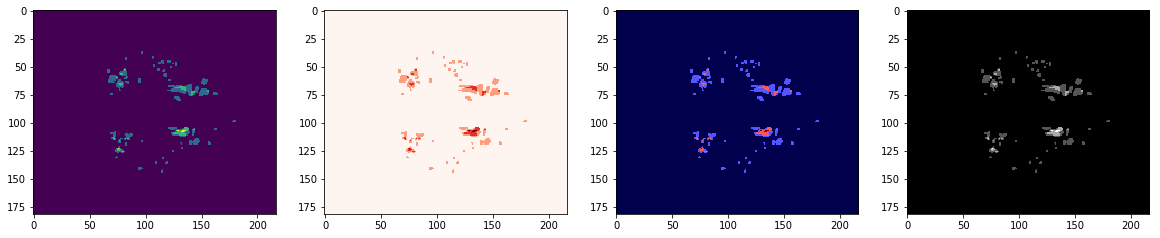

In [164]:
print("HC lesions")
plt.figure(figsize=(20, 10))
plt.title("All HC lesions summed")
plt.subplot(1, 4, 1)
plt.imshow(HC_lesion_sum[:,:,z_slice])#, cmap='Reds')
plt.subplot(1, 4, 2)
plt.imshow(HC_lesion_sum[:,:,z_slice], cmap='Reds')
plt.subplot(1, 4, 3)
plt.imshow(HC_lesion_sum[:,:,z_slice], cmap='seismic')
plt.subplot(1, 4, 4)
plt.imshow(HC_lesion_sum[:,:,z_slice], cmap='gray')
plt.show()

In [134]:
lesion_mask_filtered = (lesion_sum_filtered >= 1e-10) *1

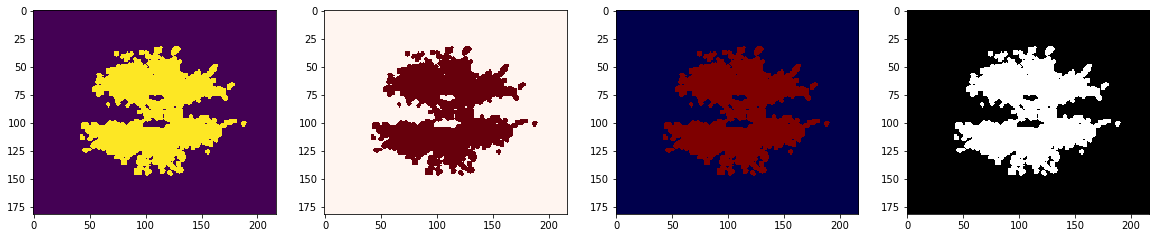

In [135]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(lesion_mask_filtered[:,:,z_slice])#, cmap='Reds')
plt.subplot(1, 4, 2)
plt.imshow(lesion_mask_filtered[:,:,z_slice], cmap='Reds')
plt.subplot(1, 4, 3)
plt.imshow(lesion_mask_filtered[:,:,z_slice], cmap='seismic')
plt.subplot(1, 4, 4)
plt.imshow(lesion_mask_filtered[:,:,z_slice], cmap='gray')
plt.show()


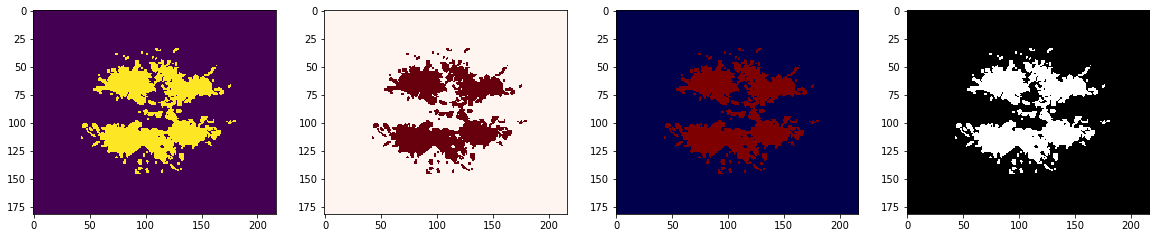

In [102]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.imshow(lesion_mask[:,:,z_slice])#, cmap='Reds')
plt.subplot(1, 4, 2)
plt.imshow(lesion_mask[:,:,z_slice], cmap='Reds')
plt.subplot(1, 4, 3)
plt.imshow(lesion_mask[:,:,z_slice], cmap='seismic')
plt.subplot(1, 4, 4)
plt.imshow(lesion_mask[:,:,z_slice], cmap='gray')
plt.show()


In [103]:
lesion_mask.shape

(182, 217, 182)

In [104]:
scan = load_nifti(df["path"][0])[:,1:,:]
# normalize scan by max scaling
scan /= np.max(scan)

In [105]:
def flip_mask(mask):
    # flips binary values in mask
    flipped_m = mask.copy()
    flipped_m[np.where(mask==1.)] = 0.
    flipped_m[np.where(mask==0.)] = 1.
    return flipped_m

In [106]:
flipped_lesion_mask = flip_mask(lesion_mask)

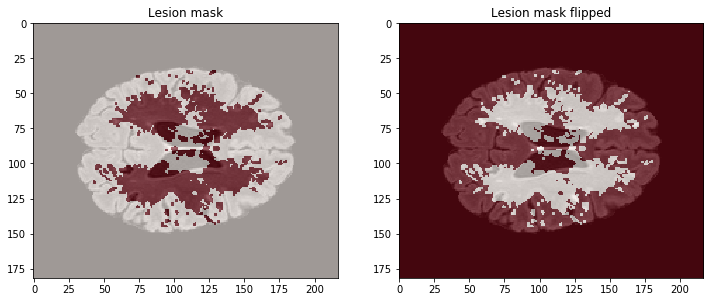

In [107]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(scan[:,:,z_slice], cmap='gray')
plt.imshow(lesion_mask[:,:,z_slice], cmap='Reds', alpha=0.6)
plt.title("Lesion mask")
plt.subplot(1, 2, 2)
plt.imshow(scan[:,:,z_slice], cmap='gray')
plt.imshow(flipped_lesion_mask[:,:,z_slice], cmap='Reds', alpha=0.6)
plt.title("Lesion mask flipped")
plt.show()

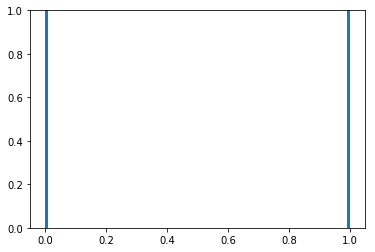

In [108]:
plt.hist(lesion_mask.flatten(), bins=100)
axes = plt.gca()
axes.set_ylim([0, 1])
plt.show()

### Zoomed lesion mask

In [109]:
zoomed_mask = zoom(lesion_mask, 1.05)

/home/fabiane/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [110]:
zoomed_mask.shape

(191, 228, 191)

In [111]:
# compute padding amount
clips = []
uneven = []
for d in range(len(zoomed_mask.shape)):
    clip_double = zoomed_mask.shape[d] - lesion_mask.shape[d]
    clips.append(int(np.floor(clip_double/2)))
    uneven.append(~clip_double % 2 == 0)

In [112]:
# in uneven cases add 1 on one side
uneven

[True, True, True]

In [113]:
s = zoomed_mask.shape
zoomed_mask = zoomed_mask[clips[0]+uneven[0]:s[0]-clips[0], clips[1]+uneven[1]:s[1]-clips[1], clips[2]+uneven[2]:s[2]-clips[2]]

In [114]:
# after zooming return to binary format
zoomed_mask[np.where(zoomed_mask>0.5)] = 1.
zoomed_mask[np.where(zoomed_mask<=0.5)] = 0.

In [115]:
flipped_zoomed_mask = flip_mask(zoomed_mask)

In [116]:
print(zoomed_mask.shape)

(182, 217, 182)


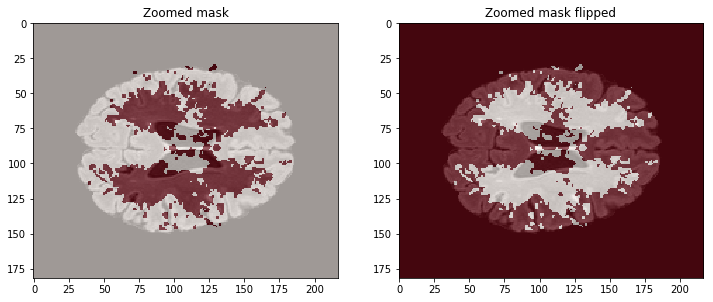

In [117]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(scan[:,:,z_slice], cmap='gray')
plt.imshow(zoomed_mask[:,:,z_slice], cmap='Reds', alpha=0.6)
plt.title("Zoomed mask")
plt.subplot(1, 2, 2)
plt.imshow(scan[:,:,z_slice], cmap='gray')
plt.imshow(flipped_zoomed_mask[:,:,z_slice], cmap='Reds', alpha=0.6)
plt.title("Zoomed mask flipped")
plt.show()

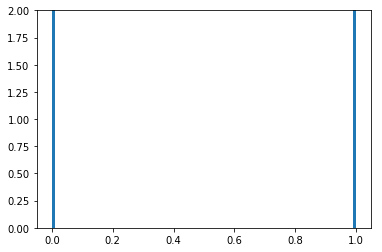

In [118]:
plt.hist(zoomed_mask.flatten(), bins=100)
axes = plt.gca()
axes.set_ylim([0, 2])
plt.show()

### Gaussian blur on mask

In [119]:
# build the smoothing kernel
sigma = 1.0     # width of kernel
x = np.arange(-3,4,1)   # coordinate arrays -- make sure they contain 0!
y = np.arange(-3,4,1)
z = np.arange(-3,4,1)
xx, yy, zz = np.meshgrid(x,y,z)
kernel = np.exp(-(xx**2 + yy**2 + zz**2)/(2*sigma**2))

In [120]:
print(kernel.shape)

(7, 7, 7)


In [121]:
# convolve kernel over image
filtered = signal.convolve(lesion_mask, kernel, mode="same")

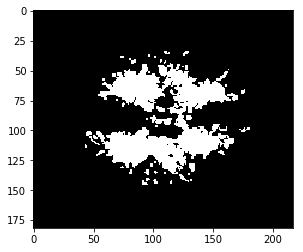

In [122]:
plt.imshow(lesion_mask[:,:,z_slice], cmap='gray')

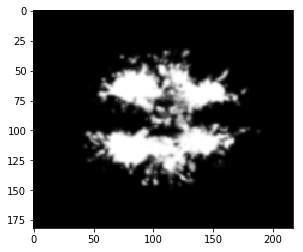

In [123]:
plt.imshow(filtered[:,:,z_slice], cmap='gray')

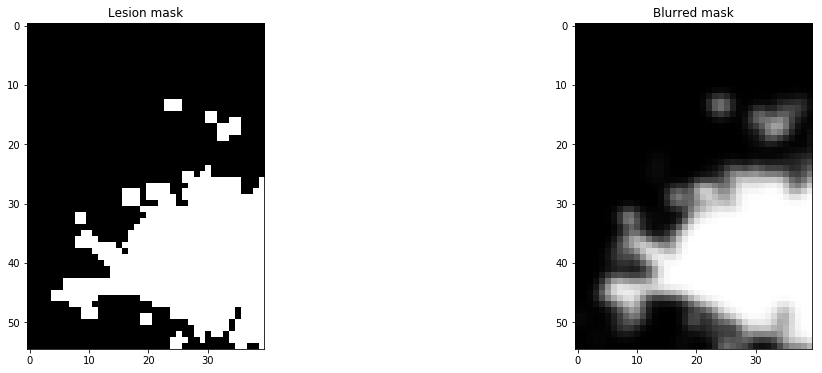

In [124]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(lesion_mask[25:80,50:90,z_slice], cmap='gray')
plt.title("Lesion mask")
plt.subplot(1, 2, 2)
plt.imshow(filtered[25:80,50:90,z_slice], cmap='gray')
plt.title("Blurred mask")
plt.show()

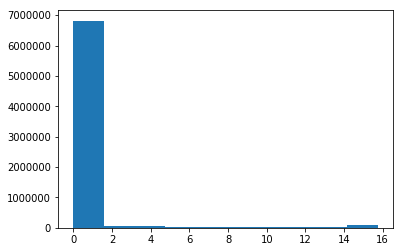

In [125]:
plt.hist(filtered.flatten())
plt.show()

In [126]:
# binarize blurred mask
filtered_bin = np.copy(filtered)
thresh = np.max(filtered_bin)/6#5.
filtered_bin[np.where(filtered>thresh)] = 1.
filtered_bin[np.where(filtered<=thresh)] = 0.

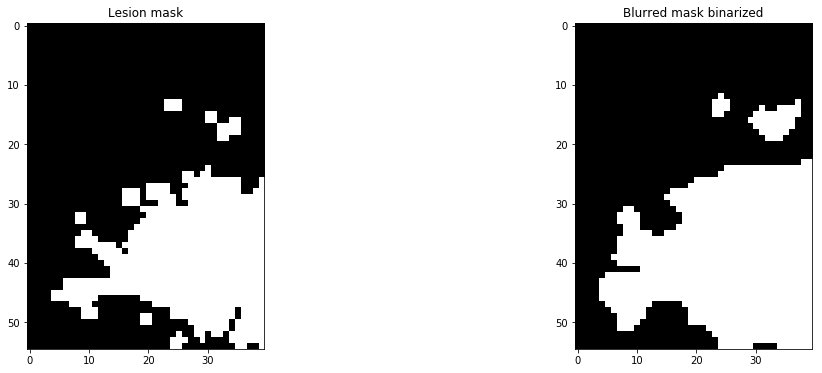

In [127]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(lesion_mask[25:80,50:90,z_slice], cmap='gray')
plt.title("Lesion mask")
plt.subplot(1, 2, 2)
plt.imshow(filtered_bin[25:80,50:90,z_slice], cmap='gray')
plt.title("Blurred mask binarized")
plt.show()

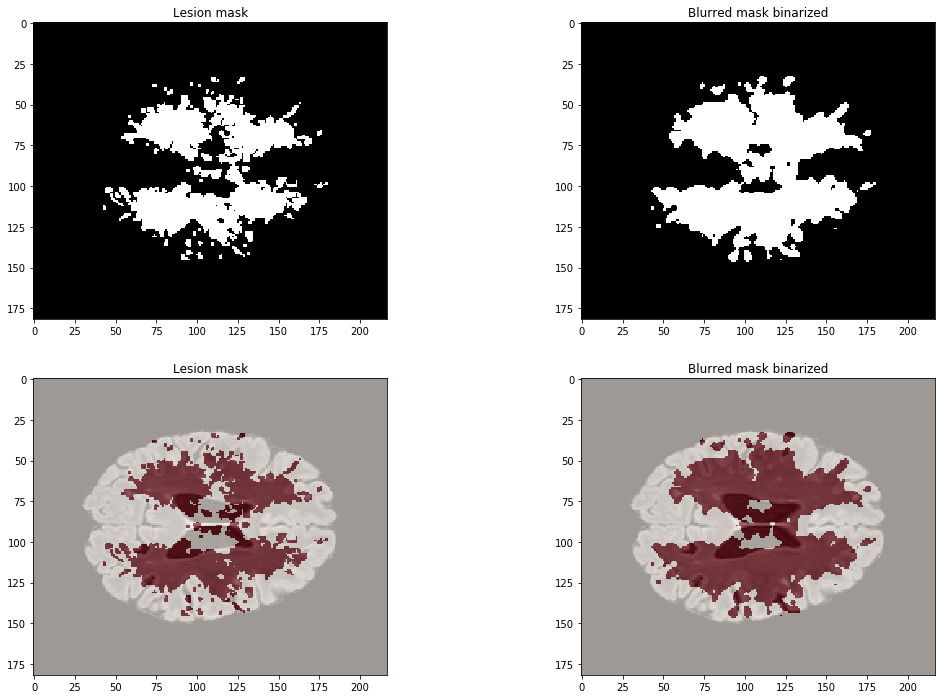

In [128]:
plt.figure(figsize=(18, 12))
#plt.subplots_adjust(hspace=0., wspace=0.)
plt.subplot(2, 2, 1)
plt.imshow(lesion_mask[:,:,z_slice], cmap='gray')
plt.title("Lesion mask")
plt.subplot(2, 2, 2)
plt.imshow(filtered_bin[:,:,z_slice], cmap='gray')
plt.title("Blurred mask binarized")
plt.subplot(2, 2, 3)
plt.imshow(scan[:,:,z_slice], cmap='gray')
plt.imshow(lesion_mask[:,:,z_slice], cmap='Reds', alpha=0.6)
plt.title("Lesion mask")
plt.subplot(2, 2, 4)
plt.imshow(scan[:,:,z_slice], cmap='gray')
plt.imshow(filtered_bin[:,:,z_slice], cmap='Reds', alpha=0.6)
plt.title("Blurred mask binarized")
plt.show()


In [129]:
flipped_blurred_mask = flip_mask(filtered_bin)

## Remove total lesion masks

In [141]:
removed = scan * flipped_lesion_mask
removed_zoomed = scan * flipped_zoomed_mask
removed_blurred = scan * flipped_blurred_mask
removed_filtered = scan * flip_mask(lesion_mask_filtered)

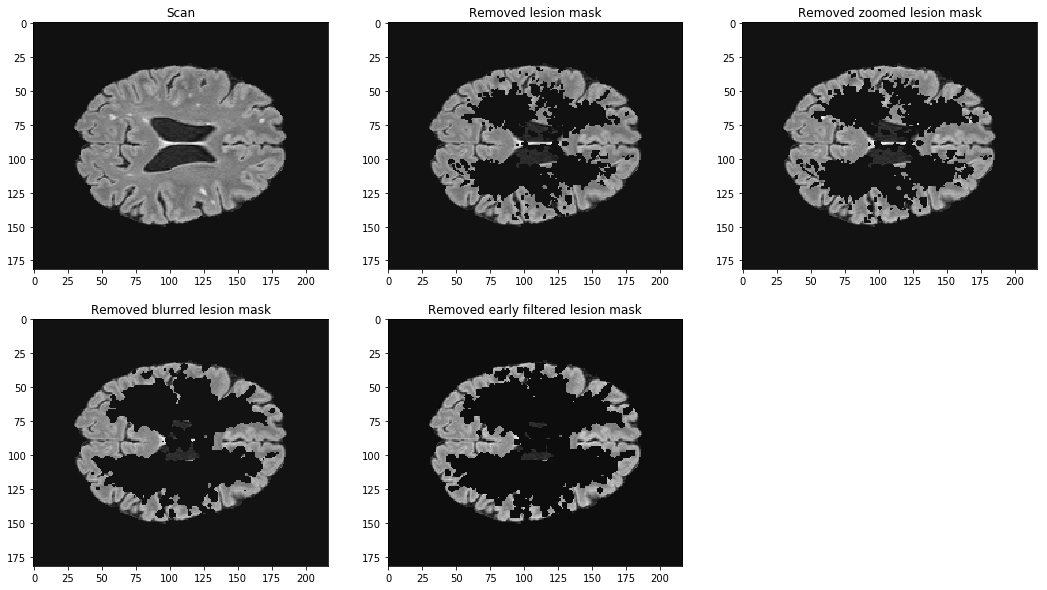

In [142]:
plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
plt.imshow(scan[:,:,z_slice], cmap='gray')
plt.title("Scan")
plt.subplot(2, 3, 2)
plt.imshow(removed[:,:,z_slice], cmap='gray')
plt.title("Removed lesion mask")
plt.subplot(2, 3, 3)
plt.imshow(removed_zoomed[:,:,z_slice], cmap='gray')
plt.title("Removed zoomed lesion mask")
plt.subplot(2, 3, 4)
plt.imshow(removed_blurred[:,:,z_slice], cmap='gray')
plt.title("Removed blurred lesion mask")
plt.subplot(2, 3, 5)
plt.imshow(removed_filtered[:,:,z_slice], cmap='gray')
plt.title("Removed early filtered lesion mask")
plt.show()

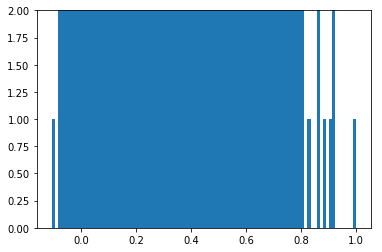

In [295]:
plt.hist(scan.flatten(), bins=100)
axes = plt.gca()
axes.set_ylim([0, 2])
plt.show()

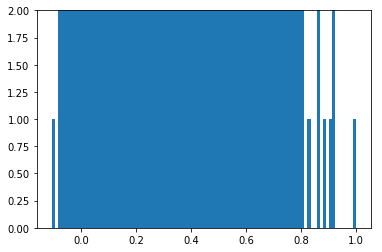

In [296]:
plt.hist(removed.flatten(), bins=100)
axes = plt.gca()
axes.set_ylim([0, 2])
plt.show()

In [331]:
doc_dir

'/data/Ritter/MS/Test/file_list_HC_MS_BET_FLAIR.csv'

In [337]:
flipped_lesion_mask.shape

(182, 217, 182)

In [338]:
nifti = nib.load(df["path"][0])

In [340]:
hdr = nifti.header

In [421]:
# store the masks
nifti_lm = nib.Nifti1Image(flipped_lesion_mask, np.eye(4), header=hdr)
nifti_lm_zoomed = nib.Nifti1Image(flipped_zoomed_mask, np.eye(4), header=hdr)
nifti_lm_blurred = nib.Nifti1Image(flipped_blurred_mask, np.eye(4), header=hdr)

#nib.save(nifti_lm, '/data/Ritter/MS/Test/total_lesion_mask.nii.gz')
#nib.save(nifti_lm_zoomed, '/data/Ritter/MS/Test/total_lesion_mask_zoomed.nii.gz')
#nib.save(nifti_lm_blurred, '/data/Ritter/MS/Test/total_lesion_mask_blurred.nii.gz')

Blur the image after masking

In [328]:
filtered_removed = signal.convolve(removed, kernel, mode="same")

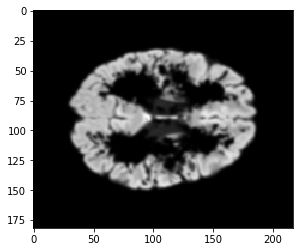

In [329]:
plt.imshow(filtered_removed[:,:,z_slice], cmap='gray')